# Key Performance Indicators (KPIs)

# In brevi

Office workers create, update, and publish documents. Whether it's creating presentations, responding to emails, or doing statistical analysis, they are creating documents. Unlike a manufacturing environment, their output appears invisible to an observer of their work process. If such a worker were to commit their documents to a Git repository, they could make their work visible . These commits could then be reported as a key performance indicator (KPI).

# Data

The data file is available here (kpis.csv). It consists of a date column and six KPI data columns. Dates are entered using ISO 8601 date format (yyyy-mm-dd). The KPI columns are the number of commits per KPI.

In [1]:
# Import the required libraries and modules.
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# These next lines are for using LaTeX.
# If you use this, all text will be LaTeX style.
#import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

In [2]:
# Read the csv data file. It is encoded in UTF-8.
# There are several columns of daily commits.
# Set "date" as the index.
commits = pd.read_csv('kpis.csv', parse_dates=True, index_col='Date')

In [3]:
# Calculate a column of total daily commits.
commits['Total']= commits['ForteF'] + commits['Private'] + \
                  commits['Support'] + commits['Jupyter'] + \
                  commits['Tableau'] + commits['KPI'] + \
                  commits['MSHA'] + commits['Anscombe'] + \
                  commits['Cholera'] + commits['ImpactEffort'] + \
                  commits['PSA'] + commits['HT1ST'] + \
                  commits['HT2ST'] + commits['HTPT'] + \
                  commits['ControlCharts'] + commits['BoxPlot']
# Calculate a column of the median of the 
# column of total daily commits.
# One day fix this so that it's not an additional
# column, but a number to plot.
commits['Median'] = commits['Total'].median()

In [4]:
# Define the graph title and subtitle, and the x and y axis labels.
title = 'Key Performance Indicator'
subtitle = 'Files Updated'
ylabel = 'Number of Files Updated'
xlabel = 'Date'

In [5]:
# Use a colour-blind friendly colormap, "Paired".
import matplotlib.cm as cm
line_private, line_support, line_total, line_median, *_ = cm.Paired.colors

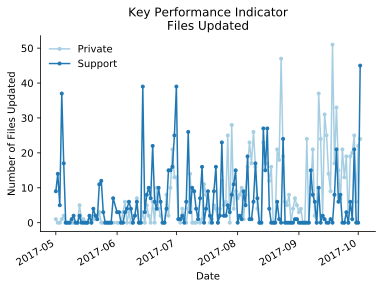

In [6]:
# Create a graph of "individual commits v. date".

# Create a single subplot.
#ax1 = plt.subplot
# Plot "total commits v. date".
#ax1 = commits[['Private', 'Support']].plot.line(legend=True, marker='o', markersize=3)
colourset = (line_private, line_support)
ax1 = commits[['Private', 'Support']].plot.line(legend=True, marker='o', markersize=3, 
                                                color=colourset)
ax1.axis('auto')
# Remove the top and right spines.
for spine in 'right', 'top':
    ax1.spines[spine].set_color('none')
ax1.set_title(title + '\n' + subtitle)
# Add the Y axis label.
ax1.set_ylabel(ylabel)
# Add the X axis label.
ax1.set_xlabel(xlabel)
# Remove the box around the legend.
ax1.legend(frameon=False)
# Save the graph as svg and pdf.
ax1.figure.savefig('kpi_commits_private_support.svg', format='svg')
ax1.figure.savefig('kpi_commits_private_support.pdf', format='pdf')

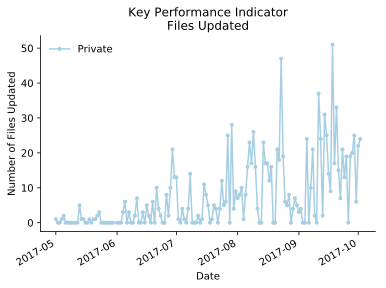

In [7]:
# Create a graph of "individual commits v. date".

# Create a single subplot.
#ax1 = plt.subplot
# Plot "total commits v. date".
#ax1 = commits[['Private'].plot.line(legend=True, marker='o', markersize=3)
colourset = (line_private)
ax1 = commits[['Private']].plot.line(legend=True, marker='o', markersize=3, 
                                                color=colourset)
ax1.axis('auto')
# Remove the top and right spines.
for spine in 'right', 'top':
    ax1.spines[spine].set_color('none')
ax1.set_title(title + '\n' + subtitle)
# Add the Y axis label.
ax1.set_ylabel(ylabel)
# Add the X axis label.
ax1.set_xlabel(xlabel)
# Remove the box around the legend.
ax1.legend(frameon=False)
# Save the graph as svg and pdf.
ax1.figure.savefig('kpi_commits_private.svg', format='svg')
ax1.figure.savefig('kpi_commits_private.pdf', format='pdf')

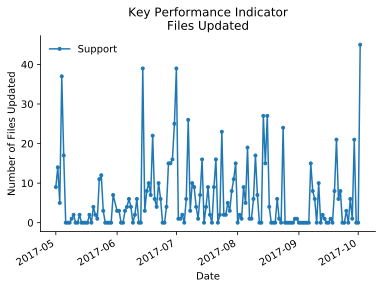

In [8]:
# Create a graph of "individual commits v. date".

# Create a single subplot.
#ax1 = plt.subplot
# Plot "total commits v. date".
#ax1 = commits[['Support']].plot.line(legend=True, marker='o', markersize=3)
colourset = (line_support)
ax1 = commits[['Support']].plot.line(legend=True, marker='o', markersize=3, 
                                                color=colourset)
ax1.axis('auto')
# Remove the top and right spines.
for spine in 'right', 'top':
    ax1.spines[spine].set_color('none')
ax1.set_title(title + '\n' + subtitle)
# Add the Y axis label.
ax1.set_ylabel(ylabel)
# Add the X axis label.
ax1.set_xlabel(xlabel)
# Remove the box around the legend.
ax1.legend(frameon=False)
# Save the graph as svg and pdf.
ax1.figure.savefig('kpi_commits_support.svg', format='svg')
ax1.figure.savefig('kpi_commits_support.pdf', format='pdf')

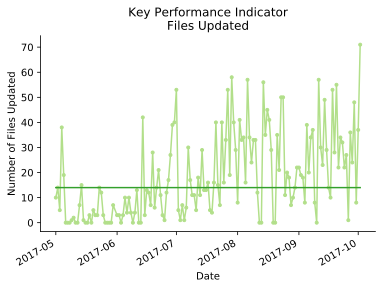

In [9]:
# Create a graph of "total commits v. date".

# Create a single subplot.
ax2 = plt.subplot(111)
# Plot "total commits v. date".
#commits['Total'].plot.line(legend=False, ax=ax2, marker='o', markersize=3).axis('auto')
commits['Total'].plot.line(legend=False, ax=ax2, marker='o', markersize=3,
                           color=line_total) \
                     .axis('auto')
#commits['Median'].plot.line(legend=False, ax=ax2).axis('auto')
commits['Median'].plot.line(legend=False, ax=ax2, color=line_median).axis('auto')
# Remove the top and right spines.
for spine in 'right', 'top':
    ax2.spines[spine].set_color('none')
# Add the graph title and subtitle.
ax2.set_title(title + '\n' + subtitle)
# Add the Y axis label.
ax2.set_ylabel(ylabel)
# Add the X axis label.
ax2.set_xlabel(xlabel)
# Save the graph as svg and pdf.
ax2.figure.savefig('kpi_commits_total.svg', format='svg')
ax2.figure.savefig('kpi_commits_total.pdf', format='pdf')

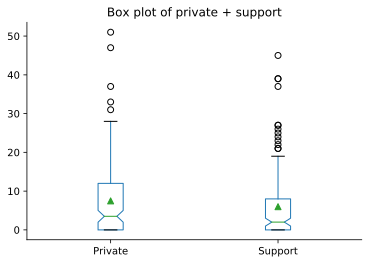

In [10]:
# Create box plots for private, support
ax = commits[['Private', 'Support']].plot.box(notch=True, showmeans=True)
ax.set_title('Box plot of private + support')
for spine in 'right', 'top':
    ax.spines[spine].set_color('none')